# Sea surface currents (SSC) prediction from Himawari-8/9 SST 

Using the Gaussian Process method of de Kreij et al., 2025.

### In this tutorial:
1. Download and preprocess Himawari-8/9 SST data
2. View the SST data and spatial and temporal gradients
3. Perform Gaussian Process regression and inspect the hyper-parameter results
4. View the surface current predictions and uncertainties

Only a single prediction time step is shwon in this tutorial. To process many time steps see tutorial 3. 

In [2]:
import os
import glob
import shutil
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from inversion_sst_gp import plots
from inversion_sst_gp import gp_regression as gpr
from inversion_sst_gp.download import himawari
from inversion_sst_gp import utils

%matplotlib inline

/home/wedge/anaconda3/envs/sstinv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Download himawari data

##### Set geographical limits and chose a time step

*Note that ~3 x 3 degree boxes are a recommended maximum area for reasonable processing on personal computers.*

In [10]:
# Define geographical and temporal boundaries for data processing
# LON_LIMITS = (114, 116)
# LAT_LIMITS = (-33, -30.5)
LON_LIMITS = (114, 115.65)
LAT_LIMITS = (-33, -30.5)   
ll_box = (LON_LIMITS, LAT_LIMITS)

# Set the time bounds - predictions will be done hourly within these limits
time_lims = ["2026-01-27T00:00:00", "2026-02-07T00:00:00"]

crop_app = 'rottnest_rca26'

# # Set the save directory for the data (recommend this directory is ignored by git if inside the repo)
# alldata_dir = os.path.join('/mnt', 'share', 'Other', 'Himawari', 'all')
# cropped_dir = os.path.join('/mnt', 'share', 'Other', 'Himawari', 'browse')
base_dir = os.path.join('/mnt', 'd', 'Work_backup', 'C_drive', 'Large_Data')
alldata_dir = os.path.join(base_dir, 'Other', 'Himawari', 'all')
cropped_dir = os.path.join(base_dir, 'Other', 'Himawari', crop_app)

##### Retrieve the required complete Himawari data files

Some files don't exist on the server. These timesteps will not get a velocity prediction.

In [11]:
# # Download the data
# himawari.get_sst_series_nasa(time_lims, alldata_dir)

In [12]:
# ### Crop himawari files (optional)

# # Setting ow=True will delete the original files after cropping (can also just set file_app='')
# himawari.crop_sst_series_nasa(alldata_dir, time_lims, ll_box, file_app=crop_app, overwrite=False)

In [13]:
# # Move the new files to another folder
# move_files = glob.glob(os.path.join(alldata_dir, f'*{crop_app}.nc'))
# for mf in move_files:
#     f_name = os.path.split(mf)[1]
#     try:
#         shutil.move(mf, os.path.join(cropped_dir, f_name))
#     except:
#         print('Skipping file: {f_name}')

In [14]:
# Load the data
ds = himawari.process_sst_series(alldata_dir, time_lims, ll_box, file_app=crop_app, sst_reduce=1)
ds

  Finished processing for 2026-01-27T00:00:00
  Finished processing for 2026-01-27T01:00:00
  Finished processing for 2026-01-27T02:00:00
  Finished processing for 2026-01-27T03:00:00
  Finished processing for 2026-01-27T04:00:00
  Finished processing for 2026-01-27T05:00:00
  Finished processing for 2026-01-27T06:00:00
  Finished processing for 2026-01-27T07:00:00
  Finished processing for 2026-01-27T08:00:00
  Finished processing for 2026-01-27T09:00:00
  Finished processing for 2026-01-27T10:00:00
  Finished processing for 2026-01-27T11:00:00
  Finished processing for 2026-01-27T12:00:00
  Finished processing for 2026-01-27T13:00:00
  Finished processing for 2026-01-27T14:00:00
  Finished processing for 2026-01-27T15:00:00
  Finished processing for 2026-01-27T16:00:00
  Finished processing for 2026-01-27T17:00:00
  Finished processing for 2026-01-27T18:00:00
  Finished processing for 2026-01-27T19:00:00
  Finished processing for 2026-01-27T20:00:00
  Finished processing for 2026-01-

<xarray.Dataset> Size: 79MB
Dimensions:    (time: 237, lat: 125, lon: 83)
Coordinates:
  * time       (time) datetime64[s] 2kB 2026-01-27 ... 2026-02-05T20:00:00
  * lat        (lat) float64 1kB -32.99 -32.97 -32.95 ... -30.55 -30.53 -30.51
  * lon        (lon) float64 664B 114.0 114.0 114.1 114.1 ... 115.6 115.6 115.7
    LON        (lat, lon) float64 83kB 114.0 114.0 114.1 ... 115.6 115.6 115.7
    LAT        (lat, lon) float64 83kB -32.99 -32.99 -32.99 ... -30.51 -30.51
    X          (lat, lon) float64 83kB -7.664e+04 -7.477e+04 ... 7.871e+04
    Y          (lat, lon) float64 83kB -1.375e+05 -1.375e+05 ... 1.375e+05
    lonc       float64 8B 114.8
    latc       float64 8B -31.75
    time_step  int64 8B 3600
Data variables:
    T          (time, lat, lon) float64 20MB nan nan nan nan ... nan nan nan nan
    dTdt       (time, lat, lon) float64 20MB nan nan nan nan ... nan nan nan nan
    dTdx       (time, lat, lon) float64 20MB nan nan nan nan ... nan nan nan nan
    dTdy       (time, lat, lon) float64 20MB nan nan nan nan ... nan nan nan nan

In [15]:
### Optional: save joined DS and delete individual cropped files
crop_app_mod = crop_app+'_2km'
ds.to_netcdf(os.path.join(cropped_dir, f'{crop_app_mod}_compiled.nc'))
ds = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app_mod}_compiled.nc'))
# ds = ds.sel(lat=slice(LAT_LIMITS[0]+0.8, LAT_LIMITS[1]-1.1), lon=slice(LON_LIMITS[0]+1.25, LON_LIMITS[1]))
ds = ds.sel(lat=slice(LAT_LIMITS[0]+0.4, LAT_LIMITS[1]-0.88), lon=slice(LON_LIMITS[0]+0.24, LON_LIMITS[1]))
ds

### Uncomment to delete individual cropped files
# for mf in move_files:
#     f_name = os.path.split(mf)[1]
#     os.remove(os.path.join(cropped_dir, f_name))

<xarray.Dataset> Size: 33MB
Dimensions:    (time: 237, lat: 61, lon: 70)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2026-01-27 ... 2026-02-05T20:00:00
  * lat        (lat) float64 488B -32.59 -32.57 -32.55 ... -31.43 -31.41 -31.39
  * lon        (lon) float64 560B 114.2 114.3 114.3 114.3 ... 115.6 115.6 115.6
    LON        (lat, lon) float64 34kB ...
    LAT        (lat, lon) float64 34kB ...
    X          (lat, lon) float64 34kB ...
    Y          (lat, lon) float64 34kB ...
    lonc       float64 8B ...
    latc       float64 8B ...
    time_step  int64 8B ...
Data variables:
    T          (time, lat, lon) float64 8MB ...
    dTdt       (time, lat, lon) float64 8MB ...
    dTdx       (time, lat, lon) float64 8MB ...
    dTdy       (time, lat, lon) float64 8MB ...

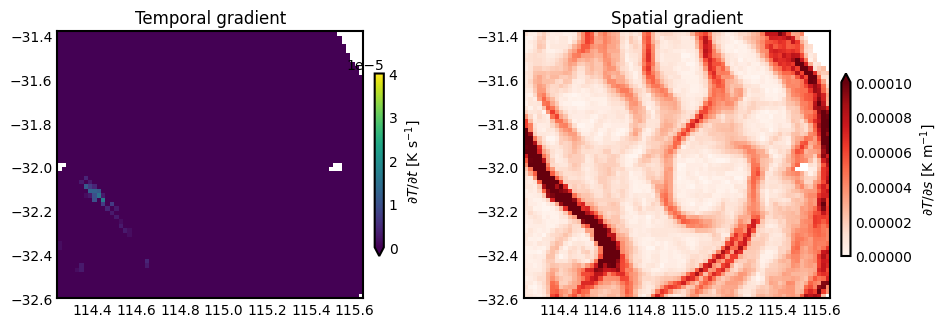

In [8]:
fig, ax = plots.plot_gradients(ds.isel(time=10), sg_names=['dTdx','dTdy'])

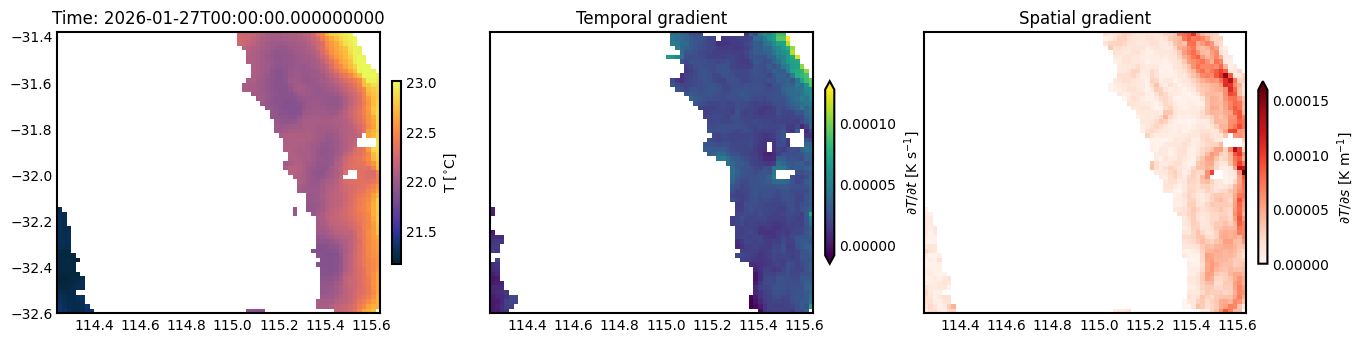

In [9]:
ani = plots.plot_data_animation(ds, anim_interval=100)
ani.save(f'{crop_app_mod}_data_full.mp4')

---
# Run the parameter optimization

##### Running on the first time step only

This is acceptable for short time series where it is expected that the hyper-parameters do not change significantly over time.

In [ ]:
# Set model hyperparameters
prop_sat = gpr.get_default_params()

# Run model
print("Running GP optimization")

# Set the time interval for refitting hyperparameters - if this is less than 1 hr, refitting will occur at every time step
refit_time = np.timedelta64(270, 'm').astype('timedelta64[ns]')

# Set a mask - assume any points with all nan are invalid
mask = ~np.all(np.isnan(ds['T'].values), axis=0)

results_name = os.path.join(cropped_dir, f'{crop_app_mod}_fits_1h.nc')
# results_step = gpr.fit_series(ds, prop_sat, refit_time, save_steps=True, save_name=results_name, callback='off', mask=mask, coverage=0.8)

Running GP optimization
Refitting hyperparameters
Saved results for time step 2026-01-27T00:00:00.000000000
Saved results for time step 2026-01-27T01:00:00.000000000
Saved results for time step 2026-01-27T02:00:00.000000000
Saved results for time step 2026-01-27T03:00:00.000000000
Saved results for time step 2026-01-27T04:00:00.000000000
Refitting hyperparameters
Saved results for time step 2026-01-27T05:00:00.000000000
Saved results for time step 2026-01-27T06:00:00.000000000
Saved results for time step 2026-01-27T07:00:00.000000000
Saved results for time step 2026-01-27T08:00:00.000000000
Saved results for time step 2026-01-27T09:00:00.000000000
Refitting hyperparameters
Saved results for time step 2026-01-27T10:00:00.000000000
Saved results for time step 2026-01-27T11:00:00.000000000
Saved results for time step 2026-01-27T12:00:00.000000000
Saved results for time step 2026-01-27T13:00:00.000000000
Saved results for time step 2026-01-27T14:00:00.000000000
Refitting hyperparameters
Sa

In [14]:
ds_results = xr.open_dataset(results_name)
ds_results.close()
ds_results

<xarray.Dataset> Size: 15kB
Dimensions:    (time: 168)
Coordinates:
  * time       (time) datetime64[ns] 1kB 2026-01-27 ... 2026-02-02T23:00:00
Data variables:
    sigma_u    (time) float64 1kB ...
    l_u        (time) float64 1kB ...
    tau_u      (time) float64 1kB ...
    sigma_v    (time) float64 1kB ...
    l_v        (time) float64 1kB ...
    tau_v      (time) float64 1kB ...
    sigma_S    (time) float64 1kB ...
    l_S        (time) float64 1kB ...
    tau_S      (time) float64 1kB ...
    sigma_tau  (time) float64 1kB ...

In [15]:
print("Calculating GP regression prediction")
ds_full = gpr.predict_series(ds.sel(time=ds_results.time), ds_results, mask=mask, coverage=0.8)
ds_full.to_netcdf(path=os.path.join(cropped_dir, f'{crop_app_mod}_predictions_1h.nc'))
ds_full = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app_mod}_predictions_1h.nc'))
ds_full

Calculating GP regression prediction


<xarray.Dataset> Size: 8MB
Dimensions:    (time: 150, lat: 30, lon: 20)
Coordinates:
  * time       (time) datetime64[ns] 1kB 2026-01-27 ... 2026-02-02T23:00:00
  * lat        (lat) float64 240B -32.19 -32.17 -32.15 ... -31.65 -31.63 -31.61
  * lon        (lon) float64 160B 115.2 115.3 115.3 115.3 ... 115.6 115.6 115.6
    LON        (lat, lon) float64 5kB ...
    LAT        (lat, lon) float64 5kB ...
    X          (lat, lon) float64 5kB ...
    Y          (lat, lon) float64 5kB ...
    lonc       float64 8B ...
    latc       float64 8B ...
    time_step  int64 8B ...
Data variables:
    T          (time, lat, lon) float64 720kB ...
    dTdt       (time, lat, lon) float64 720kB ...
    dTdx       (time, lat, lon) float64 720kB ...
    dTdy       (time, lat, lon) float64 720kB ...
    mu_u       (time, lat, lon) float64 720kB ...
    mu_v       (time, lat, lon) float64 720kB ...
    mu_S       (time, lat, lon) float64 720kB ...
    std_u      (time, lat, lon) float64 720kB ...
    std_v      (time, lat, lon) float64 720kB ...
    std_S      (time, lat, lon) float64 720kB ...
    K_uv       (time, lat, lon) float64 720kB ...

In [23]:
ds_results = ds_results.dropna(dim='time')
ds_results = utils.clean_dataset(ds_results)
ds_results_hourly = utils.make_even_hourly(ds_results.copy())

ds_full_hourly = utils.make_even_hourly(ds_full.copy())

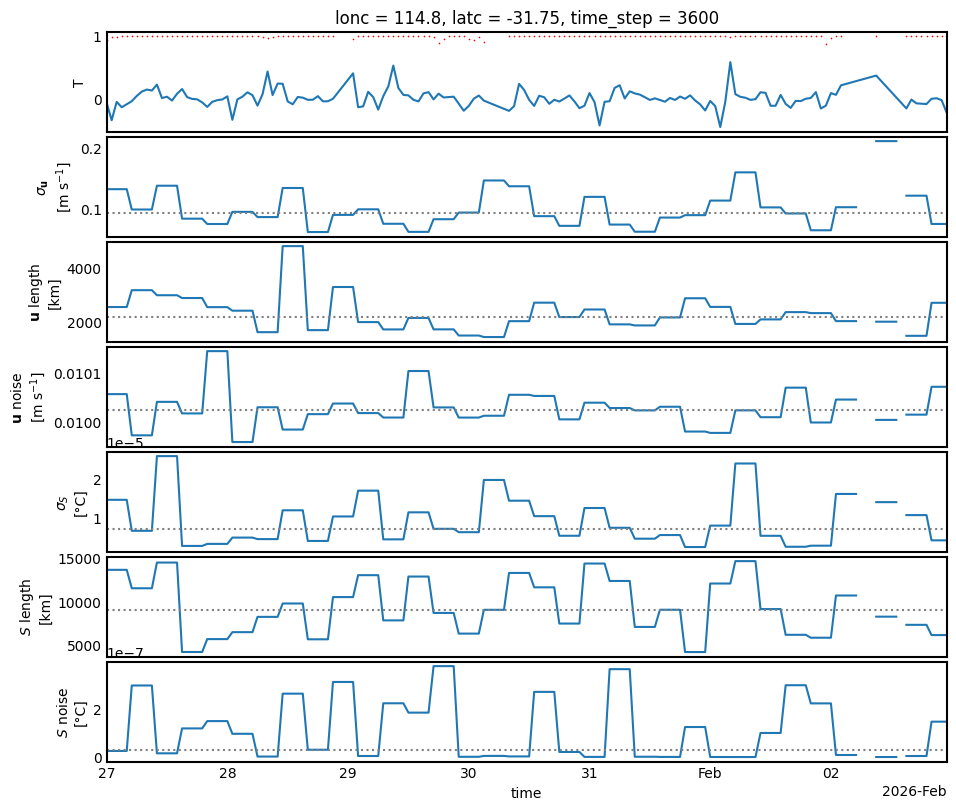

In [17]:
fig, ax = plots.plot_param_series(ds_full, ds_results)

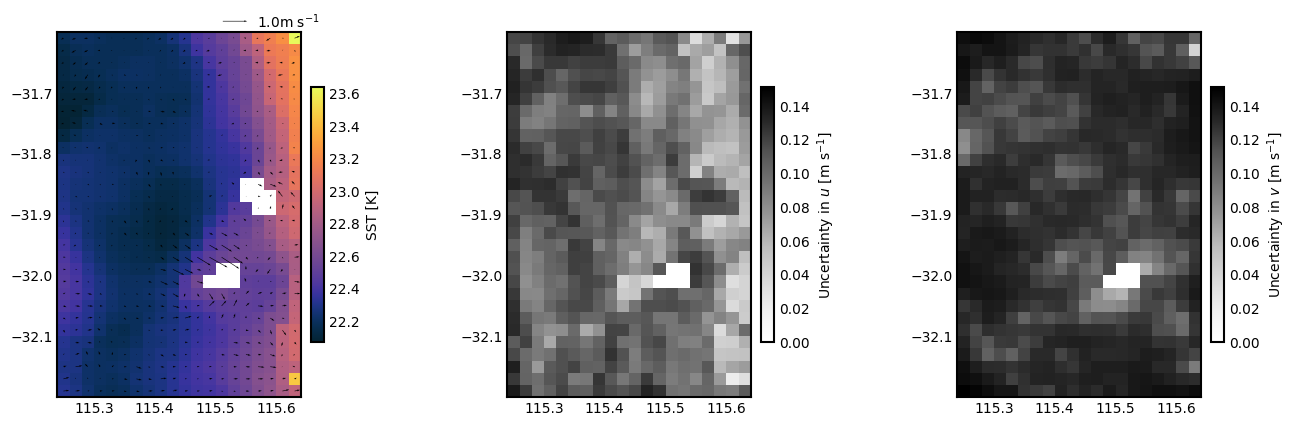

In [19]:
fig, ax = plots.plot_prediction(ds_full.isel(time=2), qv_scale=10, qk_size=1.)

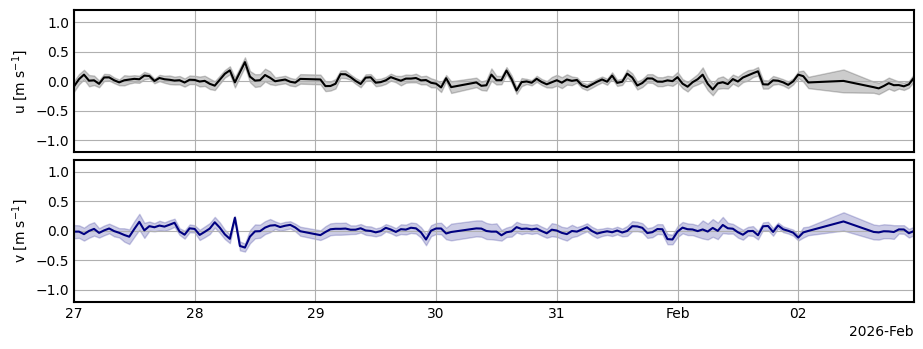

In [21]:
fig, ax = plots.plot_timeseries(ds_full, lon_pt=115.5, lat_pt=-31.9)
for x in ax:
    x.set_ylim(-1.21,1.21)
    # x.set_xlim(np.datetime64(time_lims[0]) + np.timedelta64(0,'D'), np.datetime64(time_lims[0]) + np.timedelta64(28,'D'))

/mnt/c/Users/00099894/OneDrive - The University of Western Australia/pl/uwadev/inversion-sst-gp/pkg/inversion_sst_gp/plots.py:262: RuntimeWarning: All-NaN axis encountered
  """
/mnt/c/Users/00099894/OneDrive - The University of Western Australia/pl/uwadev/inversion-sst-gp/pkg/inversion_sst_gp/plots.py:263: RuntimeWarning: All-NaN axis encountered
  # Create the figure and axes


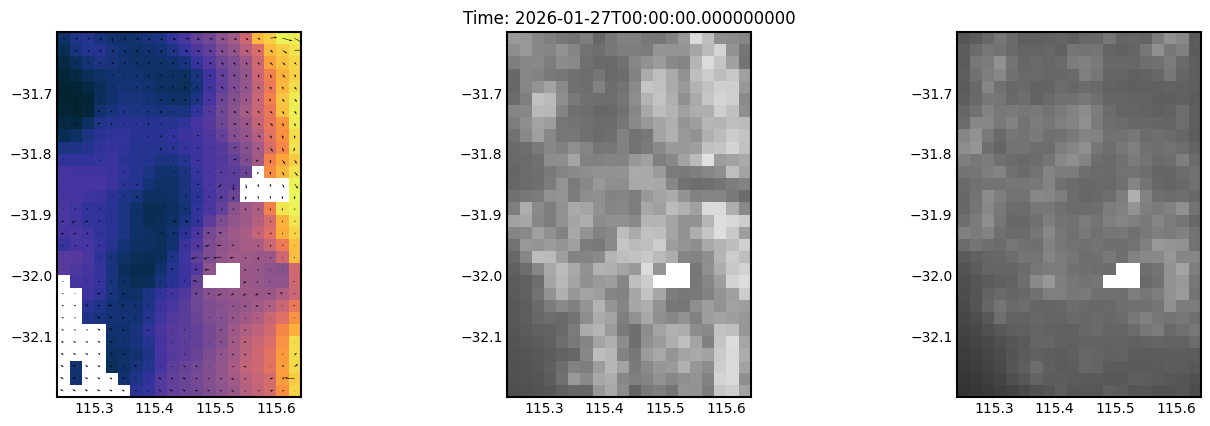

In [24]:
ani = plots.plot_prediction_animation(ds_full_hourly, qv_scale=14, anim_interval=100)
ani.save(f'{crop_app_mod}_animation_full.mp4')

In [27]:
def xarray_to_dict(ds):
    return {var: ds[var].values for var in ds.data_vars}

ds_res_median = ds_results.isel(time=0).copy()
for var in ds_res_median.data_vars:
    ds_res_median[var].values = np.nanmedian(ds_results[var].values)
# ds_res_median.to_netcdf(path=os.path.join(cropped_dir, f'{crop_app}_fits_1h_median.nc'))

ds_median_dict = xarray_to_dict(ds_res_median)

In [39]:
gpr.predict_series(ds.isel(time=[9,10]), ds_median_dict, coverage=0.8)

: 

## Some analysis

In [18]:
import pandas as pd
from wootils.filters import check_spacing, filter1d_xr

# Filter the SST inversion data
print(check_spacing(ds_full_hourly['time'].values))

# Remove bad fits
ds_full_hourly = ds_full_hourly.where(np.abs(ds_full_hourly['mu_u']) < 1.2)
ds_full_hourly = ds_full_hourly.where(np.abs(ds_full['mu_v']) < 1.2)

# # Fill missing time steps with zero
# full_time = pd.date_range(start=ds_full_hourly['time'].min().values, end=ds_full['time'].max().values, freq='h')
# ds_full = ds_full.reindex({'time': full_time}, fill_value=0)
# print(check_spacing(ds_full['time'].values))

ds_full_hourly['mu_u_lp'] = filter1d_xr(ds_full_hourly['mu_u'].fillna(0), 30, 60, ftype='lowpass', axis=0)
ds_full_hourly['mu_v_lp'] = filter1d_xr(ds_full_hourly['mu_v'].fillna(0), 30, 60, ftype='lowpass', axis=0)

True


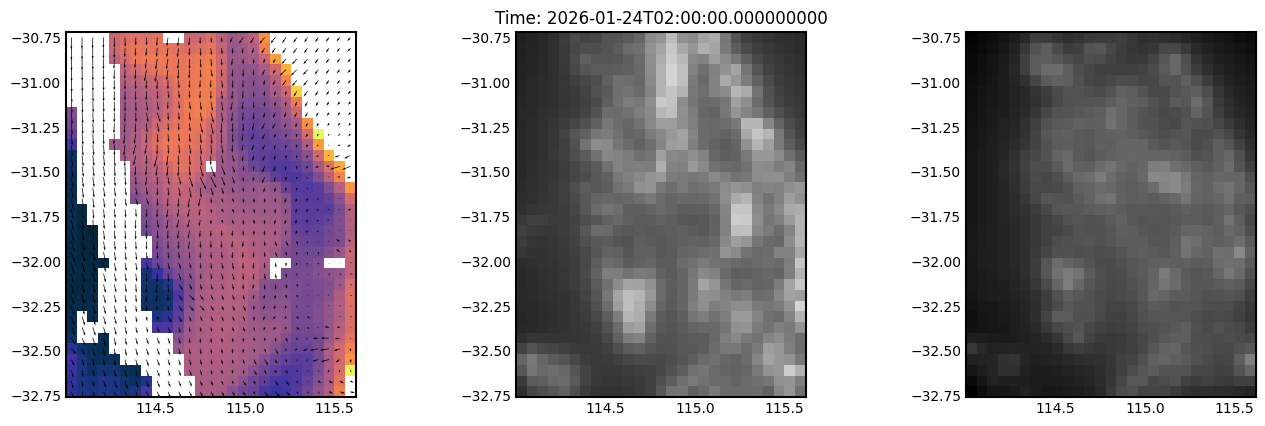

In [24]:
ani = plots.plot_prediction_animation(ds_full_hourly, qv_scale=15, u_name='mu_u_lp', v_name='mu_v_lp', anim_interval=42)
ani.save(f'{crop_app_mod}_animation_lp60hr.mp4')

: 